In [1]:
!pip install segmentation_models_pytorch warmup_scheduler albumentations -q


In [2]:
import os
import sys
import random
from glob import glob
import warnings

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

sys.path.append('/kaggle/working/notebook/experiment/2d')
from script.helper import *
from script.dataset import *
from script.metrics import *
from script.trainer import *
from script.model import *
from script.loss import *
from script.scheduler import *


## config

In [3]:
class ExtractLayers(A.ImageOnlyTransform):
    def __init__(self, in_channels, out_channels, is_train=True, always_apply=False, p=1):
        super(ExtractLayers, self).__init__(always_apply, p)
        self.is_train = is_train
        self.in_channels = in_channels
        self.out_channels = out_channels

    def apply(self, img, **params):
        if self.is_train:
            start = random.randint(0, self.in_channels-self.out_channels)
            end = start+self.out_channels
            img = img[:, :, start:end]
        else:
            img = img[:, :, 4:4+self.out_channels]
        return img


In [4]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/25-37/"
    dataset_range = train_dataset_path.split("/")[-2]
    
    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'
    in_chans = 6

    # ============== pred target =============
    target_size = 1

    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16  # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'

    epochs = 20  # 15

    warmup_factor = 10
    lr = 1e-4 / warmup_factor
    loss="bce_dice_loss"
    # ============== fold =============
    metric_direction = 'maximize'  # maximize, 'minimize'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        ExtractLayers(13, 6, is_train=True),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        ExtractLayers(13, 6, is_train=False),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


## Dataset

In [5]:
def preprocess(image_stack, fragment_i, split_i):
    # mask = image_stack != 0
    image_stack=np.clip(image_stack,a_min=10000,a_max=50000)

    # median = np.median(image_stack[mask])
    
    # deviation = np.abs(image_stack - median)
    # mad=np.median(deviation)
    # image_stack=(image_stack-median)/(mad+1)
    # image_stack=image_stack.astype(np.float32)
    return image_stack


len(train_images) = 14624
train_images[0].shape = (224, 224, 13)
train_labels[0].shape = (224, 224, 1)
train_masks[0].shape = (224, 224, 1)

len(valid_images) = 4161
valid_images[0].shape = (224, 224, 13)
valid_labels[0].shape = (224, 224, 1)



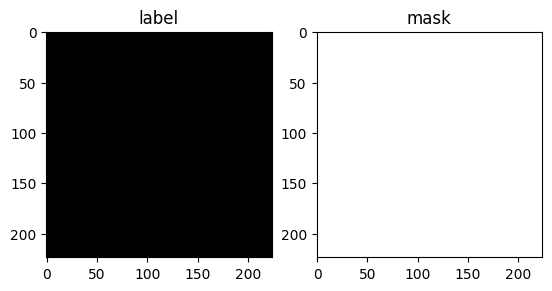

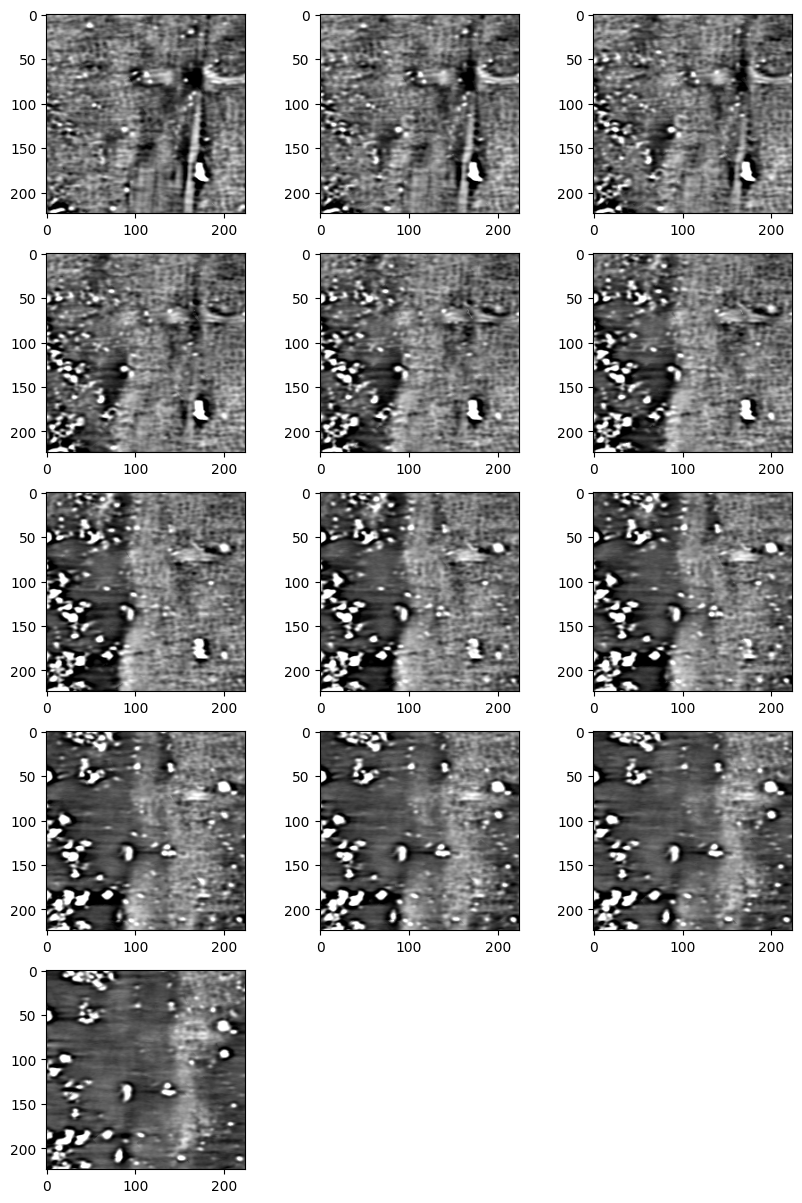

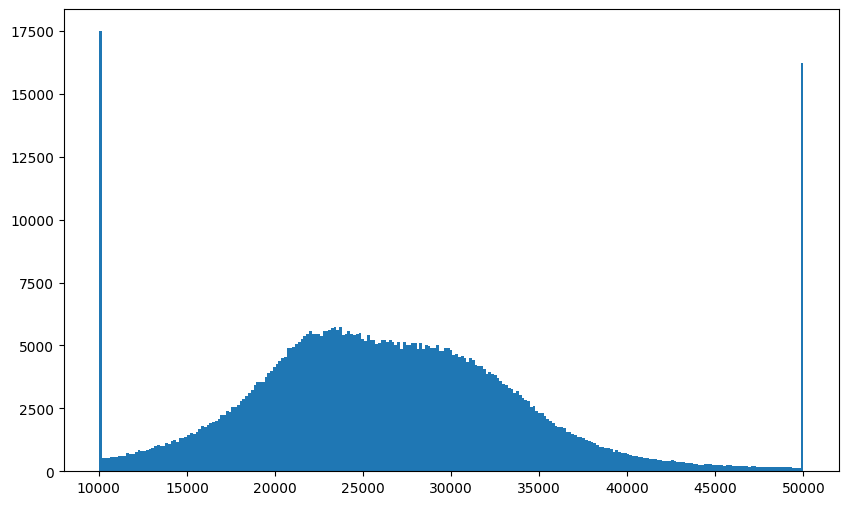

In [6]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


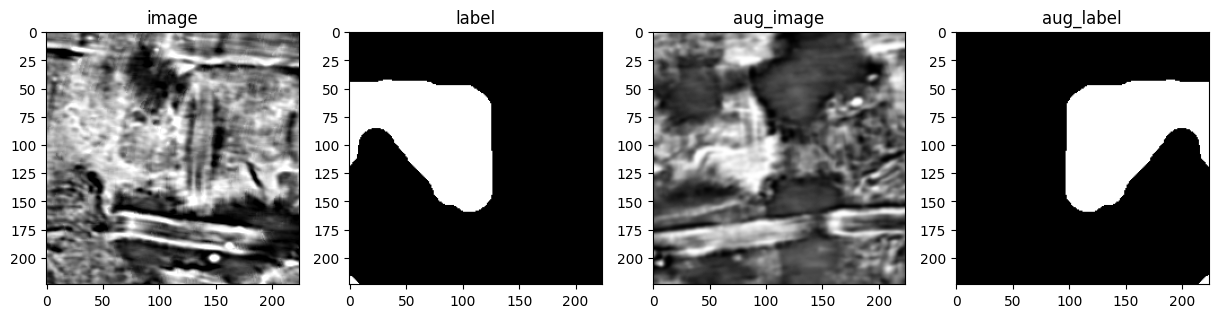

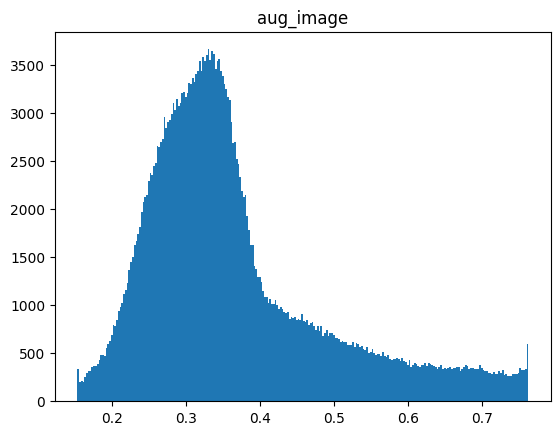

In [7]:
# confirmation
plot_dataset = CustomDataset(train_images, CFG, labels=train_labels)
visualize_dataset(plot_dataset, CFG)


## main

In [8]:
train_and_evaluate(preprocess, CFG)
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify

fold: 0


100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.10it/s]


fbeta: 0.3233
Epoch 1 - avg_train_loss: 1.3910  avg_val_loss: 1.1521  avgScore: 0.3233  time: 74s
Epoch 1 - Save Best Loss: 1.1521  Best Score: 0.3233 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.80it/s]


fbeta: 0.3965
Epoch 2 - avg_train_loss: 1.1866  avg_val_loss: 1.0392  avgScore: 0.3965  time: 72s
Epoch 2 - Save Best Loss: 1.0392  Best Score: 0.3965 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.13it/s]


fbeta: 0.3995
Epoch 3 - avg_train_loss: 1.0226  avg_val_loss: 0.9092  avgScore: 0.3995  time: 73s
Epoch 3 - Save Best Loss: 0.9092  Best Score: 0.3995 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.17it/s]


fbeta: 0.3942
Epoch 4 - avg_train_loss: 0.9080  avg_val_loss: 0.9281  avgScore: 0.3942  time: 71s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.28it/s]


fbeta: 0.4030
Epoch 5 - avg_train_loss: 0.8761  avg_val_loss: 0.9246  avgScore: 0.4030  time: 70s
Epoch 5 - Save Best Loss: 0.9246  Best Score: 0.4030 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.15it/s]


fbeta: 0.4300
Epoch 6 - avg_train_loss: 0.8316  avg_val_loss: 0.9724  avgScore: 0.4300  time: 71s
Epoch 6 - Save Best Loss: 0.9724  Best Score: 0.4300 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.22it/s]


fbeta: 0.4414
Epoch 7 - avg_train_loss: 0.8237  avg_val_loss: 0.8598  avgScore: 0.4414  time: 71s
Epoch 7 - Save Best Loss: 0.8598  Best Score: 0.4414 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.20it/s]


fbeta: 0.4594
Epoch 8 - avg_train_loss: 0.7801  avg_val_loss: 0.9303  avgScore: 0.4594  time: 71s
Epoch 8 - Save Best Loss: 0.9303  Best Score: 0.4594 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.83it/s]


fbeta: 0.4121
Epoch 9 - avg_train_loss: 0.7758  avg_val_loss: 0.9617  avgScore: 0.4121  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.84it/s]


fbeta: 0.4136
Epoch 10 - avg_train_loss: 0.7397  avg_val_loss: 0.9834  avgScore: 0.4136  time: 69s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.73it/s]


fbeta: 0.5019
Epoch 11 - avg_train_loss: 0.7132  avg_val_loss: 0.8820  avgScore: 0.5019  time: 70s
Epoch 11 - Save Best Loss: 0.8820  Best Score: 0.5019 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.71it/s]


fbeta: 0.4785
Epoch 12 - avg_train_loss: 0.7153  avg_val_loss: 0.9214  avgScore: 0.4785  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.80it/s]


fbeta: 0.4903
Epoch 13 - avg_train_loss: 0.6902  avg_val_loss: 0.8821  avgScore: 0.4903  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.77it/s]


fbeta: 0.5209
Epoch 14 - avg_train_loss: 0.6542  avg_val_loss: 0.9565  avgScore: 0.5209  time: 70s
Epoch 14 - Save Best Loss: 0.9565  Best Score: 0.5209 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.62it/s]


fbeta: 0.5030
Epoch 15 - avg_train_loss: 0.6430  avg_val_loss: 0.8467  avgScore: 0.5030  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.69it/s]


fbeta: 0.4414
Epoch 16 - avg_train_loss: 0.6287  avg_val_loss: 0.9197  avgScore: 0.4414  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.66it/s]


fbeta: 0.4983
Epoch 17 - avg_train_loss: 0.6131  avg_val_loss: 0.8673  avgScore: 0.4983  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.80it/s]


fbeta: 0.4849
Epoch 18 - avg_train_loss: 0.5991  avg_val_loss: 0.9055  avgScore: 0.4849  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.70it/s]


fbeta: 0.4756
Epoch 19 - avg_train_loss: 0.5856  avg_val_loss: 0.9059  avgScore: 0.4756  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.78it/s]


fbeta: 0.4720
Epoch 20 - avg_train_loss: 0.5665  avg_val_loss: 0.9055  avgScore: 0.4720  time: 69s

fold: 1


100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.15it/s]


fbeta: 0.3281
Epoch 1 - avg_train_loss: 1.4383  avg_val_loss: 0.8922  avgScore: 0.3281  time: 72s
Epoch 1 - Save Best Loss: 0.8922  Best Score: 0.3281 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.28it/s]


fbeta: 0.4279
Epoch 2 - avg_train_loss: 1.2200  avg_val_loss: 0.8015  avgScore: 0.4279  time: 71s
Epoch 2 - Save Best Loss: 0.8015  Best Score: 0.4279 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.32it/s]


fbeta: 0.4185
Epoch 3 - avg_train_loss: 1.0628  avg_val_loss: 0.6722  avgScore: 0.4185  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.47it/s]


fbeta: 0.4639
Epoch 4 - avg_train_loss: 0.9508  avg_val_loss: 0.6267  avgScore: 0.4639  time: 71s
Epoch 4 - Save Best Loss: 0.6267  Best Score: 0.4639 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.42it/s]


fbeta: 0.4513
Epoch 5 - avg_train_loss: 0.8978  avg_val_loss: 0.6536  avgScore: 0.4513  time: 70s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.43it/s]


fbeta: 0.5036
Epoch 6 - avg_train_loss: 0.8822  avg_val_loss: 0.6228  avgScore: 0.5036  time: 71s
Epoch 6 - Save Best Loss: 0.6228  Best Score: 0.5036 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.26it/s]


fbeta: 0.5072
Epoch 7 - avg_train_loss: 0.8197  avg_val_loss: 0.6049  avgScore: 0.5072  time: 71s
Epoch 7 - Save Best Loss: 0.6049  Best Score: 0.5072 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.30it/s]


fbeta: 0.5201
Epoch 8 - avg_train_loss: 0.8156  avg_val_loss: 0.5837  avgScore: 0.5201  time: 72s
Epoch 8 - Save Best Loss: 0.5837  Best Score: 0.5201 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.42it/s]


fbeta: 0.5604
Epoch 9 - avg_train_loss: 0.7886  avg_val_loss: 0.5868  avgScore: 0.5604  time: 71s
Epoch 9 - Save Best Loss: 0.5868  Best Score: 0.5604 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.33it/s]


fbeta: 0.5145
Epoch 10 - avg_train_loss: 0.7582  avg_val_loss: 0.6094  avgScore: 0.5145  time: 70s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.40it/s]


fbeta: 0.5614
Epoch 11 - avg_train_loss: 0.7224  avg_val_loss: 0.6097  avgScore: 0.5614  time: 71s
Epoch 11 - Save Best Loss: 0.6097  Best Score: 0.5614 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.25it/s]


fbeta: 0.5381
Epoch 12 - avg_train_loss: 0.7263  avg_val_loss: 0.5821  avgScore: 0.5381  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.37it/s]


fbeta: 0.5689
Epoch 13 - avg_train_loss: 0.6985  avg_val_loss: 0.5791  avgScore: 0.5689  time: 71s
Epoch 13 - Save Best Loss: 0.5791  Best Score: 0.5689 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.31it/s]


fbeta: 0.5526
Epoch 14 - avg_train_loss: 0.6652  avg_val_loss: 0.5786  avgScore: 0.5526  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.38it/s]


fbeta: 0.5452
Epoch 15 - avg_train_loss: 0.6530  avg_val_loss: 0.5747  avgScore: 0.5452  time: 70s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.26it/s]


fbeta: 0.5902
Epoch 16 - avg_train_loss: 0.6315  avg_val_loss: 0.5780  avgScore: 0.5902  time: 71s
Epoch 16 - Save Best Loss: 0.5780  Best Score: 0.5902 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.28it/s]


fbeta: 0.5608
Epoch 17 - avg_train_loss: 0.6117  avg_val_loss: 0.5814  avgScore: 0.5608  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.32it/s]


fbeta: 0.5911
Epoch 18 - avg_train_loss: 0.6011  avg_val_loss: 0.5704  avgScore: 0.5911  time: 71s
Epoch 18 - Save Best Loss: 0.5704  Best Score: 0.5911 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.47it/s]


fbeta: 0.6082
Epoch 19 - avg_train_loss: 0.5903  avg_val_loss: 0.5907  avgScore: 0.6082  time: 71s
Epoch 19 - Save Best Loss: 0.5907  Best Score: 0.6082 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.32it/s]


fbeta: 0.6043
Epoch 20 - avg_train_loss: 0.5758  avg_val_loss: 0.5830  avgScore: 0.6043  time: 71s

fold: 2


100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.65it/s]


fbeta: 0.3591
Epoch 1 - avg_train_loss: 1.1500  avg_val_loss: 1.1980  avgScore: 0.3591  time: 72s
Epoch 1 - Save Best Loss: 1.1980  Best Score: 0.3591 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.19it/s]


fbeta: 0.3973
Epoch 2 - avg_train_loss: 1.0395  avg_val_loss: 1.1364  avgScore: 0.3973  time: 71s
Epoch 2 - Save Best Loss: 1.1364  Best Score: 0.3973 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.46it/s]


fbeta: 0.3933
Epoch 3 - avg_train_loss: 0.9656  avg_val_loss: 1.1558  avgScore: 0.3933  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.64it/s]


fbeta: 0.5118
Epoch 4 - avg_train_loss: 0.8997  avg_val_loss: 1.0884  avgScore: 0.5118  time: 70s
Epoch 4 - Save Best Loss: 1.0884  Best Score: 0.5118 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.64it/s]


fbeta: 0.4314
Epoch 5 - avg_train_loss: 0.8365  avg_val_loss: 1.1247  avgScore: 0.4314  time: 70s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.44it/s]


fbeta: 0.4602
Epoch 6 - avg_train_loss: 0.8335  avg_val_loss: 1.1805  avgScore: 0.4602  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.44it/s]


fbeta: 0.4950
Epoch 7 - avg_train_loss: 0.8104  avg_val_loss: 1.0524  avgScore: 0.4950  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.54it/s]


fbeta: 0.5512
Epoch 8 - avg_train_loss: 0.7864  avg_val_loss: 1.0791  avgScore: 0.5512  time: 71s
Epoch 8 - Save Best Loss: 1.0791  Best Score: 0.5512 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.46it/s]


fbeta: 0.5551
Epoch 9 - avg_train_loss: 0.7536  avg_val_loss: 1.0842  avgScore: 0.5551  time: 71s
Epoch 9 - Save Best Loss: 1.0842  Best Score: 0.5551 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.55it/s]


fbeta: 0.5726
Epoch 10 - avg_train_loss: 0.7499  avg_val_loss: 1.0643  avgScore: 0.5726  time: 71s
Epoch 10 - Save Best Loss: 1.0643  Best Score: 0.5726 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.64it/s]


fbeta: 0.5413
Epoch 11 - avg_train_loss: 0.7188  avg_val_loss: 1.0596  avgScore: 0.5413  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.80it/s]


fbeta: 0.5634
Epoch 12 - avg_train_loss: 0.7096  avg_val_loss: 1.0801  avgScore: 0.5634  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.81it/s]


fbeta: 0.5769
Epoch 13 - avg_train_loss: 0.6762  avg_val_loss: 1.0624  avgScore: 0.5769  time: 71s
Epoch 13 - Save Best Loss: 1.0624  Best Score: 0.5769 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.54it/s]


fbeta: 0.5644
Epoch 14 - avg_train_loss: 0.6536  avg_val_loss: 1.1296  avgScore: 0.5644  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.51it/s]


fbeta: 0.5726
Epoch 15 - avg_train_loss: 0.6423  avg_val_loss: 1.1066  avgScore: 0.5726  time: 70s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.43it/s]


fbeta: 0.5343
Epoch 16 - avg_train_loss: 0.6302  avg_val_loss: 1.0708  avgScore: 0.5343  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.57it/s]


fbeta: 0.5663
Epoch 17 - avg_train_loss: 0.6137  avg_val_loss: 1.0773  avgScore: 0.5663  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.42it/s]


fbeta: 0.5865
Epoch 18 - avg_train_loss: 0.5969  avg_val_loss: 1.0432  avgScore: 0.5865  time: 71s
Epoch 18 - Save Best Loss: 1.0432  Best Score: 0.5865 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.50it/s]


fbeta: 0.5878
Epoch 19 - avg_train_loss: 0.5923  avg_val_loss: 1.0753  avgScore: 0.5878  time: 70s
Epoch 19 - Save Best Loss: 1.0753  Best Score: 0.5878 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.49it/s]


fbeta: 0.5805
Epoch 20 - avg_train_loss: 0.5774  avg_val_loss: 1.0863  avgScore: 0.5805  time: 70s

fold: 3


100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.43it/s]


fbeta: 0.3340
Epoch 1 - avg_train_loss: 1.4050  avg_val_loss: 1.1543  avgScore: 0.3340  time: 72s
Epoch 1 - Save Best Loss: 1.1543  Best Score: 0.3340 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.64it/s]


fbeta: 0.4166
Epoch 2 - avg_train_loss: 1.1844  avg_val_loss: 1.0623  avgScore: 0.4166  time: 71s
Epoch 2 - Save Best Loss: 1.0623  Best Score: 0.4166 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.60it/s]


fbeta: 0.4330
Epoch 3 - avg_train_loss: 1.0113  avg_val_loss: 0.9684  avgScore: 0.4330  time: 70s
Epoch 3 - Save Best Loss: 0.9684  Best Score: 0.4330 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.48it/s]


fbeta: 0.5413
Epoch 4 - avg_train_loss: 0.8815  avg_val_loss: 0.9118  avgScore: 0.5413  time: 71s
Epoch 4 - Save Best Loss: 0.9118  Best Score: 0.5413 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.46it/s]


fbeta: 0.5495
Epoch 5 - avg_train_loss: 0.8554  avg_val_loss: 0.9217  avgScore: 0.5495  time: 71s
Epoch 5 - Save Best Loss: 0.9217  Best Score: 0.5495 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.53it/s]


fbeta: 0.5101
Epoch 6 - avg_train_loss: 0.8295  avg_val_loss: 0.9231  avgScore: 0.5101  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.54it/s]


fbeta: 0.5671
Epoch 7 - avg_train_loss: 0.8264  avg_val_loss: 0.9309  avgScore: 0.5671  time: 71s
Epoch 7 - Save Best Loss: 0.9309  Best Score: 0.5671 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.52it/s]


fbeta: 0.5560
Epoch 8 - avg_train_loss: 0.8101  avg_val_loss: 0.9127  avgScore: 0.5560  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.43it/s]


fbeta: 0.5965
Epoch 9 - avg_train_loss: 0.7941  avg_val_loss: 0.8706  avgScore: 0.5965  time: 70s
Epoch 9 - Save Best Loss: 0.8706  Best Score: 0.5965 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.38it/s]


fbeta: 0.6281
Epoch 10 - avg_train_loss: 0.7437  avg_val_loss: 0.8606  avgScore: 0.6281  time: 71s
Epoch 10 - Save Best Loss: 0.8606  Best Score: 0.6281 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.58it/s]


fbeta: 0.5657
Epoch 11 - avg_train_loss: 0.7147  avg_val_loss: 0.9678  avgScore: 0.5657  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.64it/s]


fbeta: 0.6004
Epoch 12 - avg_train_loss: 0.7141  avg_val_loss: 0.8543  avgScore: 0.6004  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.63it/s]


fbeta: 0.6054
Epoch 13 - avg_train_loss: 0.7013  avg_val_loss: 0.8470  avgScore: 0.6054  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.52it/s]


fbeta: 0.6156
Epoch 14 - avg_train_loss: 0.6753  avg_val_loss: 0.8610  avgScore: 0.6156  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.48it/s]


fbeta: 0.5939
Epoch 15 - avg_train_loss: 0.6522  avg_val_loss: 0.8767  avgScore: 0.5939  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.56it/s]


fbeta: 0.6226
Epoch 16 - avg_train_loss: 0.6388  avg_val_loss: 0.8588  avgScore: 0.6226  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.46it/s]


fbeta: 0.6193
Epoch 17 - avg_train_loss: 0.6257  avg_val_loss: 0.8734  avgScore: 0.6193  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.66it/s]


fbeta: 0.5946
Epoch 18 - avg_train_loss: 0.6065  avg_val_loss: 0.8880  avgScore: 0.5946  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.47it/s]


fbeta: 0.6535
Epoch 19 - avg_train_loss: 0.5974  avg_val_loss: 0.8703  avgScore: 0.6535  time: 70s
Epoch 19 - Save Best Loss: 0.8703  Best Score: 0.6535 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.49it/s]


fbeta: 0.6456
Epoch 20 - avg_train_loss: 0.5868  avg_val_loss: 0.8676  avgScore: 0.6456  time: 71s

fold: 4


100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.22it/s]


fbeta: 0.2914
Epoch 1 - avg_train_loss: 1.2667  avg_val_loss: 1.0500  avgScore: 0.2914  time: 73s
Epoch 1 - Save Best Loss: 1.0500  Best Score: 0.2914 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.40it/s]


fbeta: 0.4117
Epoch 2 - avg_train_loss: 1.1186  avg_val_loss: 0.9014  avgScore: 0.4117  time: 73s
Epoch 2 - Save Best Loss: 0.9014  Best Score: 0.4117 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.36it/s]


fbeta: 0.4715
Epoch 3 - avg_train_loss: 1.0091  avg_val_loss: 0.7490  avgScore: 0.4715  time: 73s
Epoch 3 - Save Best Loss: 0.7490  Best Score: 0.4715 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.74it/s]


fbeta: 0.3540
Epoch 4 - avg_train_loss: 0.9178  avg_val_loss: 0.8677  avgScore: 0.3540  time: 72s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.38it/s]


fbeta: 0.3688
Epoch 5 - avg_train_loss: 0.8834  avg_val_loss: 0.8587  avgScore: 0.3688  time: 73s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.48it/s]


fbeta: 0.4242
Epoch 6 - avg_train_loss: 0.8540  avg_val_loss: 0.7690  avgScore: 0.4242  time: 73s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.46it/s]


fbeta: 0.5654
Epoch 7 - avg_train_loss: 0.8000  avg_val_loss: 0.6861  avgScore: 0.5654  time: 73s
Epoch 7 - Save Best Loss: 0.6861  Best Score: 0.5654 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.50it/s]


fbeta: 0.4924
Epoch 8 - avg_train_loss: 0.7876  avg_val_loss: 0.7329  avgScore: 0.4924  time: 73s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.47it/s]


fbeta: 0.5126
Epoch 9 - avg_train_loss: 0.7902  avg_val_loss: 0.6872  avgScore: 0.5126  time: 72s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.44it/s]


fbeta: 0.5115
Epoch 10 - avg_train_loss: 0.7528  avg_val_loss: 0.6870  avgScore: 0.5115  time: 73s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.48it/s]


fbeta: 0.4911
Epoch 11 - avg_train_loss: 0.7476  avg_val_loss: 0.6975  avgScore: 0.4911  time: 73s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.28it/s]


fbeta: 0.4649
Epoch 12 - avg_train_loss: 0.6898  avg_val_loss: 0.7311  avgScore: 0.4649  time: 73s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.44it/s]


fbeta: 0.5311
Epoch 13 - avg_train_loss: 0.6749  avg_val_loss: 0.6673  avgScore: 0.5311  time: 72s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.41it/s]


fbeta: 0.5567
Epoch 14 - avg_train_loss: 0.6649  avg_val_loss: 0.6816  avgScore: 0.5567  time: 72s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.37it/s]


fbeta: 0.5141
Epoch 15 - avg_train_loss: 0.6612  avg_val_loss: 0.6856  avgScore: 0.5141  time: 73s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.46it/s]


fbeta: 0.4853
Epoch 16 - avg_train_loss: 0.6419  avg_val_loss: 0.7173  avgScore: 0.4853  time: 73s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.44it/s]


fbeta: 0.5012
Epoch 17 - avg_train_loss: 0.6105  avg_val_loss: 0.7121  avgScore: 0.5012  time: 72s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.48it/s]


fbeta: 0.5066
Epoch 18 - avg_train_loss: 0.5989  avg_val_loss: 0.7072  avgScore: 0.5066  time: 72s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.50it/s]


fbeta: 0.4655
Epoch 19 - avg_train_loss: 0.5837  avg_val_loss: 0.7492  avgScore: 0.4655  time: 72s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.42it/s]


fbeta: 0.5047
Epoch 20 - avg_train_loss: 0.5845  avg_val_loss: 0.7058  avgScore: 0.5047  time: 73s

{"status":200,"message":"ok"}

In [9]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)

fbeta: 0.5209
fbeta: 0.6082
fbeta: 0.5878
fbeta: 0.6535
fbeta: 0.5654


In [10]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.5868


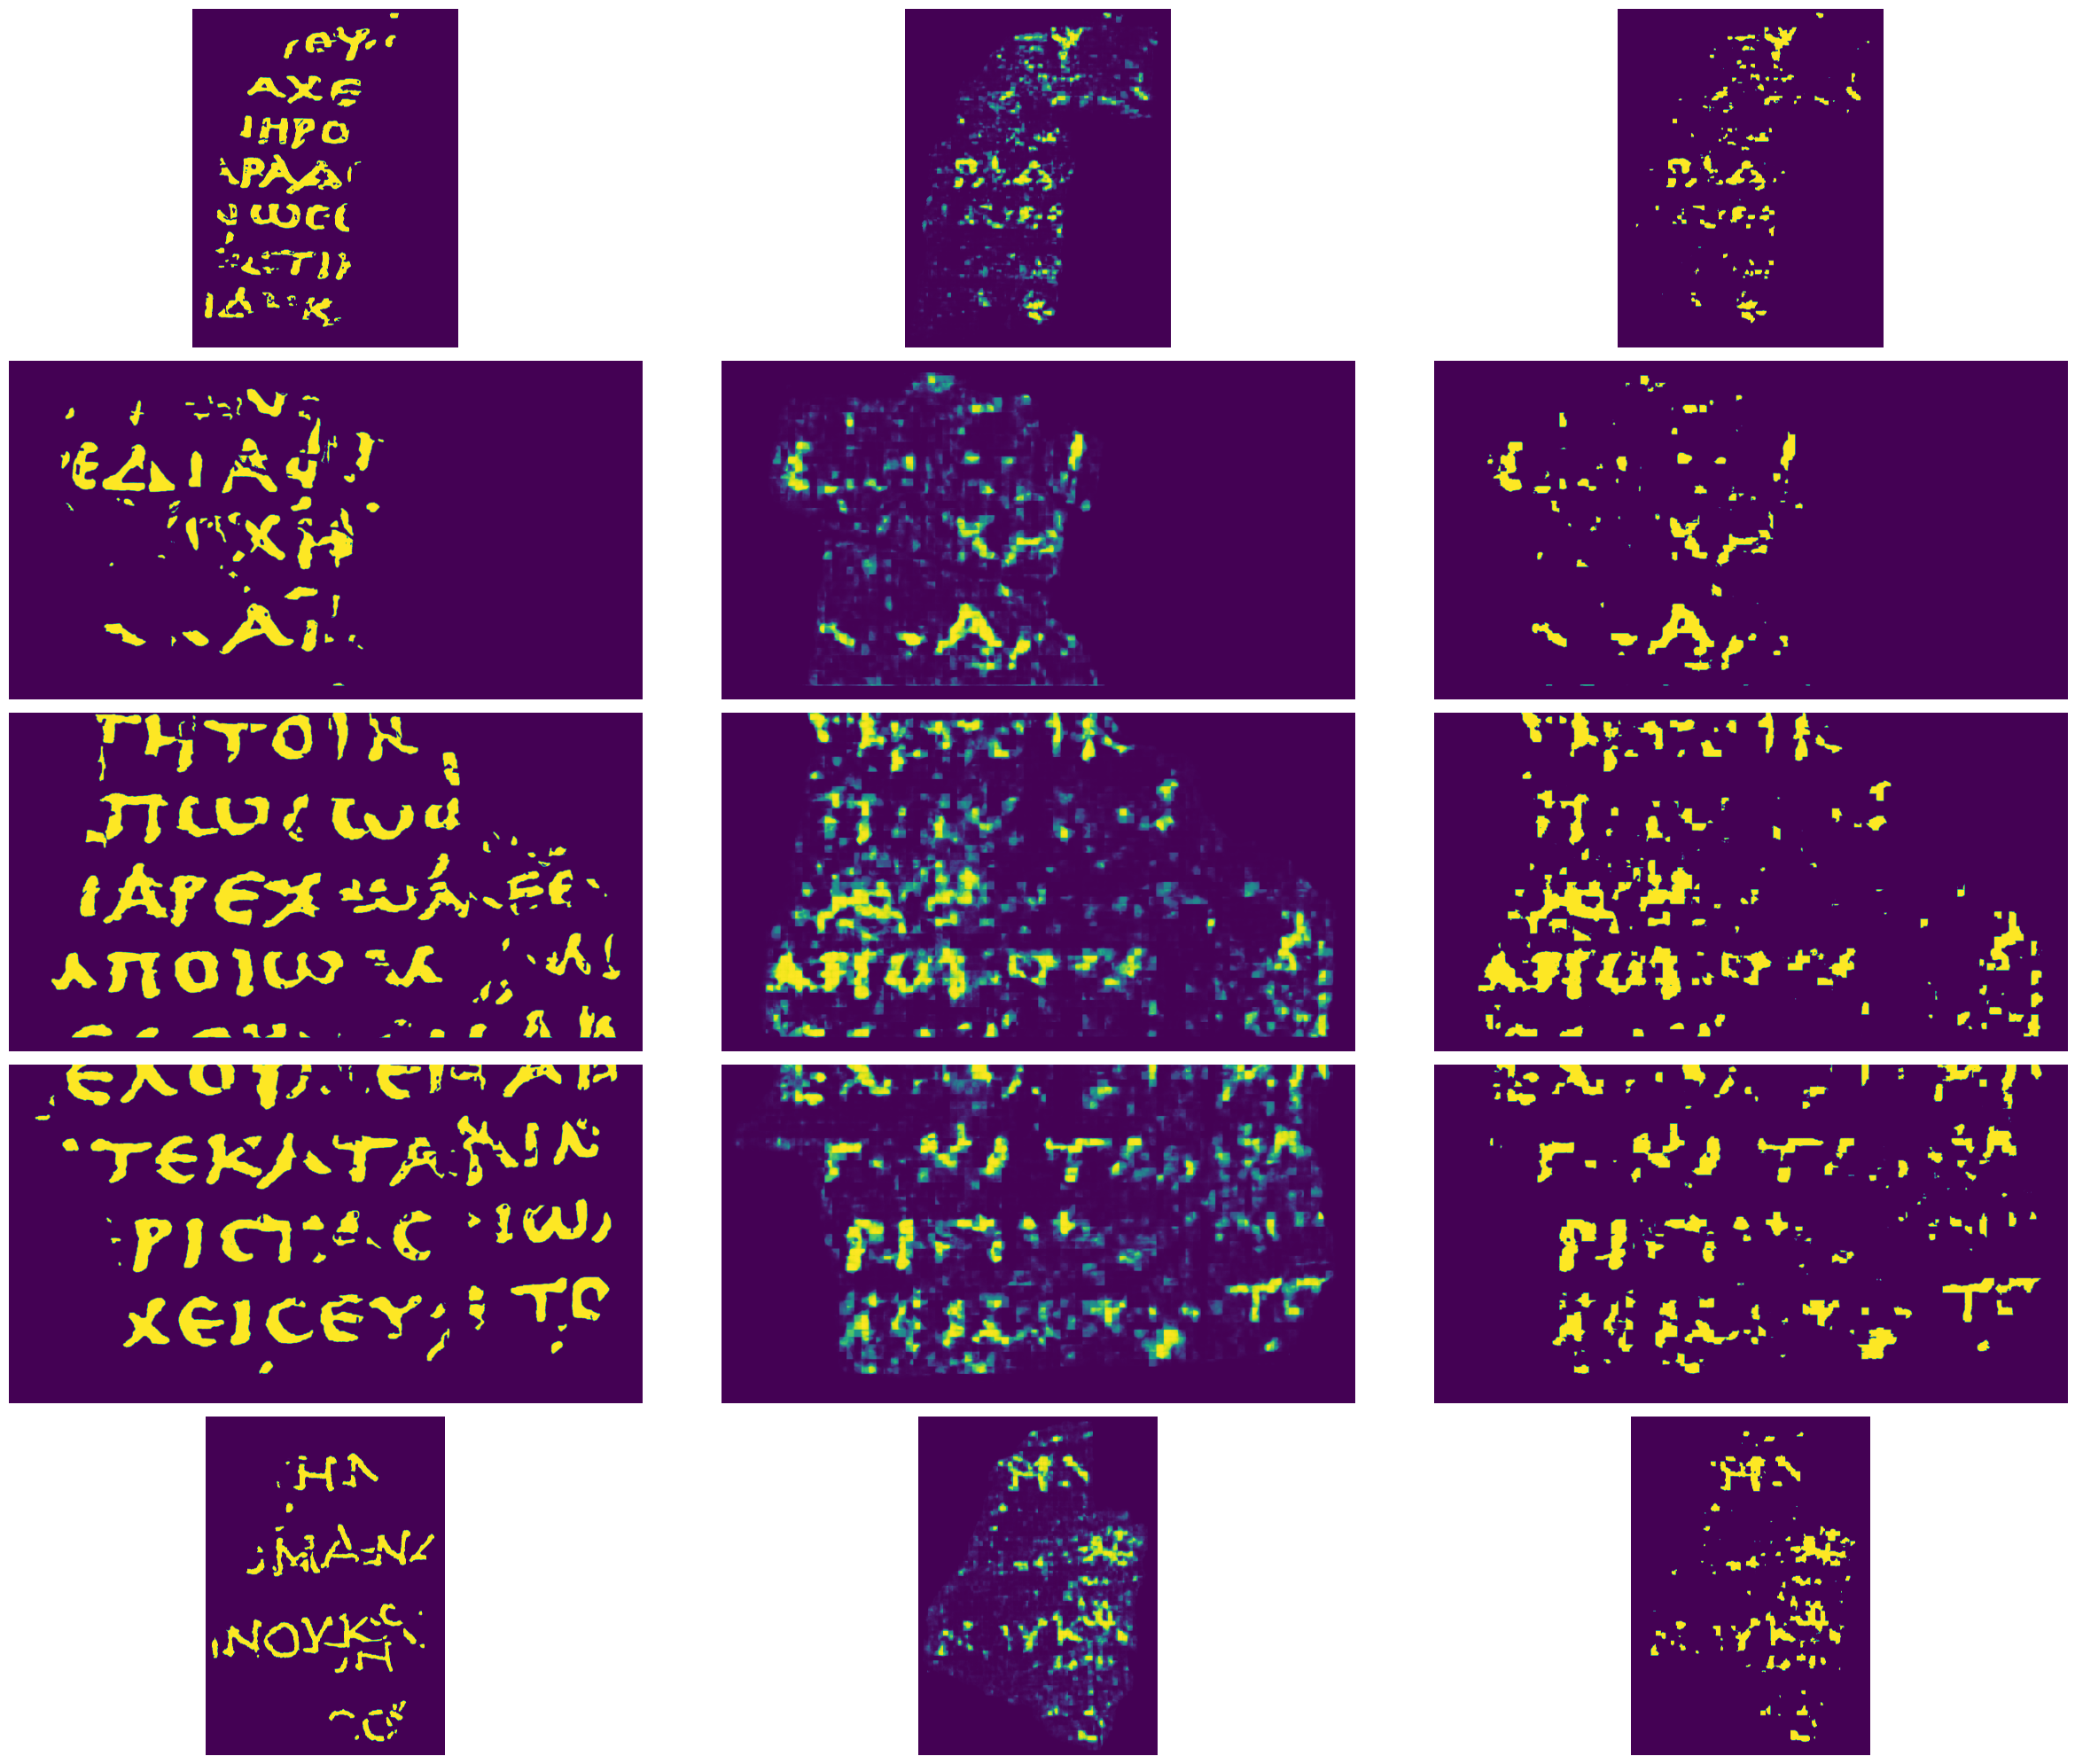

In [11]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)